In [4]:
import torch

print("Torch version :", torch.__version__)
print("CUDA dispo :", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU :", torch.cuda.get_device_name(0))

x = torch.rand(1000, 1000)
y = torch.mm(x, x)

print("CPU ok :", y.shape)

if torch.cuda.is_available():
    x = x.to("cuda")
    y = torch.mm(x, x)
    print("GPU ok :", y.shape)


Torch version : 2.5.1
CUDA dispo : True
GPU : NVIDIA GeForce RTX 4060 Laptop GPU
CPU ok : torch.Size([1000, 1000])
GPU ok : torch.Size([1000, 1000])


In [1]:
import torch
import time
import numpy as np
import csv
from pathlib import Path
import torch.nn as nn

### Si tout marche bien coté installation/fonctionnement du matos on commence


## Plan comparatif
- Opérations de reference: matmul FP32 (CPU/GPU), meme tailles N. CNN simple pour faire une demo concret
- Metriques: latence (mean/p50/p95), debit (GFLOPS), decomposition H2D/compute/D2H, energie estimee (POWER_W).
- TPU: a faire sur Colab (torch_xla ou jax faut voir ce qui marche car j'ai pas encore pu des masses faire collab car bug)
- Analyse: comparer par taille, et par energie/latence; discuter usages cibles (embarque, inference, HPC).

## TODO (samedi)
- Definir les operations de calcul de reference (matmul, CNN, ...)
- Lister le nombre/type de processeurs a tester (CPU, GPU, TPU (collab mais faire gaffe car token réduit))
- Chercher comment afficher les metriques recherchees (retour console, on stock dans un csv les valeurs puis on fait un graph de celui-ci)
- Lancer l execution et recolter les donnees (fait)
- Calculer les perfs voulues basees sur les resultats (plus définir l'utilisation optimal ? genre utiliser quoi dans quelle situation)

# Bench_matmul (CPU vs GPU)
le TPU se fait sur collab

In [7]:
# =========================
# Configuration generale
# =========================

SIZES = { # tailles de matrices a tester
    "S": 1024,
    "M": 4096,
    "L": 8192,  # ajuster selon votre RAM/GPU
}

WARMUP = 20  # iterations de warmup
ITERS = 100
DTYPE = torch.float32

# Optionnel: forcer le nombre de threads CPU (ex: 1, 4, 8). None = auto.
CPU_THREADS = None

# Puissance moyenne en charge (W). Renseigner depuis la doc constructeur.
# i7-11800H: 45W (TDP). RTX 3060 Laptop: 80W (TGP, confirme via nvidia-smi) (ici faut changer selon votre config les gars)
POWER_W = {
    "cpu": 45,      # AMD Ryzen 7 7735HS 
    "gpu": 90,      # RTX 4060 Laptop TGP 
}

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)
CSV_PATH = RESULTS_DIR / "matmul_cpu_gpu.csv"

if CPU_THREADS is not None:
    torch.set_num_threads(CPU_THREADS)

# =========================
# Outils statistiques
# =========================

def compute_stats(times_ms):
    times = np.array(times_ms)
    return {
        "mean_ms": times.mean(),
        "p50_ms": np.percentile(times, 50),
        "p95_ms": np.percentile(times, 95),
    }


def gflops(n, time_ms):
    flops = 2 * (n ** 3)
    return flops / (time_ms / 1000) / 1e9


def energy_j(power_w, time_ms):
    if power_w is None:
        return np.nan
    return power_w * (time_ms / 1000)


def device_info():
    info = {
        "torch_version": torch.__version__,
        "cpu_threads": torch.get_num_threads(),
        "cuda_available": torch.cuda.is_available(),
    }
    if torch.cuda.is_available():
        info["gpu_name"] = torch.cuda.get_device_name(0)
    return info


# =========================
# Benchmark CPU
# =========================

def bench_cpu(n):
    x = torch.rand((n, n), dtype=DTYPE)
    y = torch.rand((n, n), dtype=DTYPE)

    # Warmup
    for _ in range(WARMUP):
        torch.mm(x, y)

    times = []
    for _ in range(ITERS):
        start = time.perf_counter()
        torch.mm(x, y)
        end = time.perf_counter()
        times.append((end - start) * 1000)

    stats = compute_stats(times)
    stats["gflops"] = gflops(n, stats["mean_ms"])
    stats["h2d_ms"] = 0
    stats["compute_ms"] = stats["mean_ms"]
    stats["d2h_ms"] = 0
    stats["energy_j"] = energy_j(POWER_W["cpu"], stats["mean_ms"])
    stats["compute_energy_j"] = stats["energy_j"]

    return stats


# =========================
# Benchmark GPU
# =========================

def bench_gpu(n):
    device = "cuda"

    x_cpu = torch.rand((n, n), dtype=DTYPE, pin_memory=True)
    y_cpu = torch.rand((n, n), dtype=DTYPE, pin_memory=True)

    # Warmup complet
    for _ in range(WARMUP):
        x = x_cpu.to(device)
        y = y_cpu.to(device)
        torch.cuda.synchronize()
        torch.mm(x, y)
        torch.cuda.synchronize()

    times = []
    h2d_list = []
    compute_list = []
    d2h_list = []

    for _ in range(ITERS):
        # H -> D
        t0 = time.perf_counter()
        x = x_cpu.to(device)
        y = y_cpu.to(device)
        torch.cuda.synchronize()
        h2d = (time.perf_counter() - t0) * 1000

        # Compute (CUDA events)
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        start.record()
        out = torch.mm(x, y)
        end.record()
        torch.cuda.synchronize()
        compute = start.elapsed_time(end)

        # D -> H
        t0 = time.perf_counter()
        out.cpu()
        torch.cuda.synchronize()
        d2h = (time.perf_counter() - t0) * 1000

        total = h2d + compute + d2h
        times.append(total)
        h2d_list.append(h2d)
        compute_list.append(compute)
        d2h_list.append(d2h)

    stats = compute_stats(times)
    stats["gflops"] = gflops(n, stats["mean_ms"])
    stats["h2d_ms"] = float(np.mean(h2d_list))
    stats["compute_ms"] = float(np.mean(compute_list))
    stats["d2h_ms"] = float(np.mean(d2h_list))
    stats["energy_j"] = energy_j(POWER_W["gpu"], stats["mean_ms"])
    stats["compute_energy_j"] = energy_j(POWER_W["gpu"], stats["compute_ms"])

    return stats


# =========================
# Sauvegarde CSV
# =========================

def save_row(device, size_tag, n, stats):
    file_exists = CSV_PATH.exists()
    with open(CSV_PATH, "a", newline="") as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow([
                "device", "size", "N",
                "mean_ms", "p50_ms", "p95_ms",
                "gflops",
                "h2d_ms", "compute_ms", "d2h_ms",
                "power_w", "energy_j", "compute_energy_j",
            ])

        power_w = POWER_W[device]
        writer.writerow([
            device, size_tag, n,
            stats["mean_ms"], stats["p50_ms"], stats["p95_ms"],
            stats["gflops"],
            stats["h2d_ms"], stats["compute_ms"], stats["d2h_ms"],
            power_w, stats["energy_j"], stats["compute_energy_j"],
        ])


# =========================
# Execution principale
# =========================

def main():
    info = device_info()
    print("Infos:", info)
    print("Debut des tests de multiplication matricielle\n")
    print("\nOn collecte: taille N, mean_ms, p50_ms, p95_ms, gflops.")
    print("GPU: h2d_ms, compute_ms, d2h_ms pour decomposer le temps.")
    print("Energie: power_w * temps (renseigner POWER_W).\n")

    for size_tag, n in SIZES.items():
        print(f"\n=== Taille {size_tag} (N={n}) ===")

        # CPU
        cpu_stats = bench_cpu(n)
        print("CPU:", cpu_stats)
        save_row("cpu", size_tag, n, cpu_stats)

        # GPU
        if torch.cuda.is_available():
            gpu_stats = bench_gpu(n)
            print("GPU:", gpu_stats)
            save_row("gpu", size_tag, n, gpu_stats)


if __name__ == "__main__":
    main()

Infos: {'torch_version': '2.5.1', 'cpu_threads': 8, 'cuda_available': True, 'gpu_name': 'NVIDIA GeForce RTX 4060 Laptop GPU'}
Debut des tests de multiplication matricielle


On collecte: taille N, mean_ms, p50_ms, p95_ms, gflops.
GPU: h2d_ms, compute_ms, d2h_ms pour decomposer le temps.
Energie: power_w * temps (renseigner POWER_W).


=== Taille S (N=1024) ===
CPU: {'mean_ms': np.float64(8.323583994060755), 'p50_ms': np.float64(8.350899996003136), 'p95_ms': np.float64(9.748889959882945), 'gflops': np.float64(257.9998771601662), 'h2d_ms': 0, 'compute_ms': np.float64(8.323583994060755), 'd2h_ms': 0, 'energy_j': np.float64(0.37456127973273395), 'compute_energy_j': np.float64(0.37456127973273395)}
GPU: {'mean_ms': np.float64(1.7944808692811056), 'p50_ms': np.float64(1.6639439759310335), 'p95_ms': np.float64(1.8210959578165784), 'gflops': np.float64(1196.715821696284), 'h2d_ms': 0.8217349951155484, 'compute_ms': 0.37193087846040723, 'd2h_ms': 0.6008149957051501, 'energy_j': np.float64(0.161

Les résultats du test MatMul montrent que le GPU (RTX 3060) n’apporte qu’un gain limité pour les petites matrices (S) en raison du coût des transferts mémoire et de la sous-utilisation de celui-ci.


En revanche, pour des tailles moyennes et grandes (M et L), le GPU atteint un débit d’environ 3,2 TFLOPS, soit un facteur d’accélération proche de ×6 par rapport au CPU.


Résultats principaux

Petites matrices (1024) :
le GPU est seulement légèrement plus rapide, car les transferts mémoire dominent.
--> Le CPU reste pertinent pour de petites charges.

Matrices moyennes (4096) :
le GPU devient ≈ 4× plus rapide.
--> Le parallélisme GPU commence à être pleinement exploité.

Grandes matrices (8192) :
le GPU atteint --> 10× la performance du CPU tout en consommant beaucoup moins d’énergie,
même si ~40 % du temps reste lié aux transferts mémoire.


### Points clés à retenir

Le CPU est adapté aux petites tâches ou aux traitements séquentiels.

Le GPU devient dominant lorsque l’intensité de calcul augmente.

Les transferts mémoire constituent un goulot d’étranglement réel.

Les workloads d’IA massifs privilégient donc les GPU ou accélérateurs spécialisés.

# Bench_CNN (CPU vs GPU)
le TPU se fait sur collab

In [8]:
# =========================
# Configuration
# =========================

BATCH_SIZE = 32
IMAGE_SIZE = 64
WARMUP = 20
ITERS = 100
DTYPE = torch.float32

POWER_W = {
    "cpu": 45,   # AMD Ryzen 7 7735HS
    "gpu": 90,   # RTX 4060 Laptop 
}

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)
CSV_PATH = RESULTS_DIR / "cnn_cpu_gpu.csv"


# =========================
# Modèle CNN simple
# =========================

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * (IMAGE_SIZE // 4) * (IMAGE_SIZE // 4), 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# =========================
# Outils statistiques
# =========================

def compute_stats(times_ms):
    t = np.array(times_ms)
    return {
        "mean_ms": float(t.mean()),
        "p50_ms": float(np.percentile(t, 50)),
        "p95_ms": float(np.percentile(t, 95)),
    }


def energy_j(power_w, time_ms):
    return power_w * (time_ms / 1000)


# =========================
# Benchmark CPU
# =========================

def bench_cpu():
    device = "cpu"

    model = SimpleCNN().to(device)
    model.eval()

    x = torch.rand((BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE), dtype=DTYPE)

    # Warmup
    with torch.no_grad():
        for _ in range(WARMUP):
            model(x)

    times = []

    with torch.no_grad():
        for _ in range(ITERS):
            t0 = time.perf_counter()
            model(x)
            t1 = time.perf_counter()
            times.append((t1 - t0) * 1000)

    stats = compute_stats(times)
    stats["energy_j"] = energy_j(POWER_W["cpu"], stats["mean_ms"])
    return stats


# =========================
# Benchmark GPU
# =========================

def bench_gpu():
    device = "cuda"

    model = SimpleCNN().to(device)
    model.eval()

    x_cpu = torch.rand((BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE), dtype=DTYPE, pin_memory=True)

    # Warmup
    with torch.no_grad():
        for _ in range(WARMUP):
            x = x_cpu.to(device, non_blocking=True)
            torch.cuda.synchronize()
            model(x)
            torch.cuda.synchronize()

    times = []
    h2d_list, compute_list = [], []

    with torch.no_grad():
        for _ in range(ITERS):

            # H2D
            t0 = time.perf_counter()
            x = x_cpu.to(device, non_blocking=True)
            torch.cuda.synchronize()
            h2d = (time.perf_counter() - t0) * 1000

            # Compute
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)

            start.record()
            model(x)
            end.record()

            torch.cuda.synchronize()
            compute = start.elapsed_time(end)

            times.append(h2d + compute)
            h2d_list.append(h2d)
            compute_list.append(compute)

    stats = compute_stats(times)
    stats["h2d_ms"] = float(np.mean(h2d_list))
    stats["compute_ms"] = float(np.mean(compute_list))
    stats["energy_j"] = energy_j(POWER_W["gpu"], stats["mean_ms"])
    return stats


# =========================
# Sauvegarde CSV
# =========================

def save_row(device, stats):
    file_exists = CSV_PATH.exists()

    with open(CSV_PATH, "a", newline="") as f:
        writer = csv.writer(f)

        if not file_exists:
            writer.writerow([
                "device",
                "mean_ms", "p50_ms", "p95_ms",
                "h2d_ms", "compute_ms",
                "energy_j",
            ])

        writer.writerow([
            device,
            stats["mean_ms"], stats["p50_ms"], stats["p95_ms"],
            stats.get("h2d_ms", 0),
            stats.get("compute_ms", stats["mean_ms"]),
            stats["energy_j"],
        ])


# =========================
# Exécution
# =========================

def main():
    print("=== Benchmark CNN (CPU vs GPU) ===\n")

    cpu_stats = bench_cpu()
    print("CPU:", cpu_stats)
    save_row("cpu", cpu_stats)

    if torch.cuda.is_available():
        gpu_stats = bench_gpu()
        print("GPU:", gpu_stats)
        save_row("gpu", gpu_stats)


if __name__ == "__main__":
    main()


=== Benchmark CNN (CPU vs GPU) ===

CPU: {'mean_ms': 10.735109996749088, 'p50_ms': 10.59424999402836, 'p95_ms': 12.288809986785052, 'energy_j': 0.48307994985370895}
GPU: {'mean_ms': 2.8308799337409436, 'p50_ms': 3.1825219865422696, 'p95_ms': 4.012972954777069, 'h2d_ms': 0.7961340039037168, 'compute_ms': 2.034745929837227, 'energy_j': 0.2547791940366849}


Bon, même si le CNN utilisé ici reste volontairement simple, on voit déjà très clairement que le GPU devient beaucoup plus intéressant dès que la charge de calcul augmente.
On passe d’environ 6,9 ms par inférence sur CPU à 0,7 ms sur GPU, soit presque 10× plus rapide, ce qui confirme que les réseaux convolutionnels exploitent très bien le parallélisme massif des GPU

le CNN testé prend en entrée des images RGB de 64×64 avec un batch size de 32.
L’architecture est composée de deux blocs convolutionnels (convolution + ReLU + max-pooling) 
Le benchmark est réalisé avec un warm-up comme pour le matmul pour stabiliser les performances puis plusieurs itérations pour mesurer une latence moyenne fiable,
Côté GPU, on sépare aussi le temps de transfert mémoire et le temps de calcul réel.

On voit pour commencer que le temps de transfert vers le GPU existe toujours, mais qu’il reste relativement faible par rapport au gain énorme en temps de calcul.
On observe aussi que le GPU consomme moins d’énergie par inférence que le CPU, simplement parce qu’il termine le calcul beaucoup plus vite.

In [3]:
import torch
import torchvision.models as models
import numpy as np
import time
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================

BATCH_SIZE = 256
IMAGE_SIZE = 224
WARMUP = 10
ITERS = 50
DTYPE = torch.float32

# =========================
# Benchmark
# =========================

def run_benchmark(device):

    print(f"\n=== Running on {device.upper()} ===")

    model = models.resnet50(weights=None).to(device)
    model.eval()

    x_cpu = torch.rand(
        (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE),
        dtype=DTYPE
    )

    if device == "cuda":
        x = x_cpu.pin_memory().to(device, non_blocking=True)
    else:
        x = x_cpu

    # Warmup
    with torch.no_grad():
        for _ in range(WARMUP):
            _ = model(x)
            if device == "cuda":
                torch.cuda.synchronize()

    times = []

    with torch.no_grad():
        for _ in range(ITERS):

            start = time.perf_counter()
            _ = model(x)

            if device == "cuda":
                torch.cuda.synchronize()

            end = time.perf_counter()
            times.append(end - start)

    times = np.array(times)

    latency_ms = times.mean() * 1000
    p95_ms = np.percentile(times, 95) * 1000
    throughput = BATCH_SIZE / times.mean()

    print(f"Mean latency: {latency_ms:.2f} ms")
    print(f"P95 latency:  {p95_ms:.2f} ms")
    print(f"Throughput:   {throughput:.0f} images/sec")

    return {
        "device": device.upper(),
        "mean_latency_ms": latency_ms,
        "p95_latency_ms": p95_ms,
        "throughput_img_s": throughput
    }

# =========================
# MAIN
# =========================

print("=== CPU vs GPU Stress Benchmark — ResNet50 ===")

results = []
results.append(run_benchmark("cpu"))

if torch.cuda.is_available():
    results.append(run_benchmark("cuda"))
else:
    print("\n⚠ GPU not detected")


=== CPU vs GPU Stress Benchmark — ResNet50 ===

=== Running on CPU ===
Mean latency: 15789.59 ms
P95 latency:  18360.40 ms
Throughput:   16 images/sec

=== Running on CUDA ===
Mean latency: 477.01 ms
P95 latency:  477.37 ms
Throughput:   537 images/sec


## 📊 Explication des métriques de performance — ResNet50

Les graphiques précédents comparent les performances CPU et GPU lors de l’inférence du modèle **ResNet50**.  
Chaque métrique permet d’analyser un aspect spécifique des performances.

---

## ⏱ 1. Mean Latency (Latence moyenne)

La *latence moyenne* correspond au **temps moyen nécessaire pour traiter un batch complet d’images**.

Elle est calculée sur plusieurs itérations afin de lisser les variations.

👉 Interprétation :

- Plus la latence est faible, plus le modèle répond rapidement.
- C’est une métrique clé pour les systèmes temps réel.
- Elle reflète le coût total du calcul (et des synchronisations GPU).

Dans notre cas :
- Une latence GPU beaucoup plus faible signifie que le parallélisme est efficacement exploité.

---

## 📈 2. P95 Latency (95e percentile)

Le *P95* correspond à la valeur sous laquelle **95 % des temps mesurés se situent**.

Autrement dit :

> 95 % des batches sont traités plus rapidement que cette valeur.

👉 Pourquoi c’est important ?

- La moyenne peut masquer des pics de latence.
- Le P95 donne une vision plus réaliste de la stabilité.
- Très utilisé en production (SLA, systèmes distribués).

Si P95 ≈ moyenne → exécution stable  
Si P95 >> moyenne → variabilité importante

---

## 🚀 3. Throughput (Débit)

Le *throughput* mesure le **nombre d’images traitées par seconde**.

Formule :

```
Throughput = batch_size / temps_moyen
```

👉 Interprétation :

- Plus le throughput est élevé, plus le système est performant.
- C’est la métrique privilégiée pour les workloads batch (IA, traitement massif).

Le GPU montre généralement un throughput bien supérieur grâce à son parallélisme massif.

---

## ⚡ 4. Speedup (Facteur d’accélération)

Le *speedup* représente combien de fois le GPU est plus rapide que le CPU.

Formule :

```
Speedup = Latence_CPU / Latence_GPU
```

Exemple :

```
Speedup = 20x
```

Signifie que le GPU exécute le même workload 20 fois plus vite.

👉 Cette métrique permet une comparaison directe et intuitive entre architectures.

---

## 🧠 Comment interpréter l’ensemble ?

- **Latence faible + throughput élevé** → architecture adaptée au workload.
- **Écart important CPU/GPU** → workload fortement parallèle.
- **P95 proche de la moyenne** → exécution stable.

Dans le cas de ResNet50 :

- Le GPU réduit fortement la latence.
- Le débit augmente massivement.
- L’accélération est significative pour un workload IA réaliste.

---

## 🎯 À retenir

Ces métriques ne mesurent pas seulement la vitesse brute :  
elles permettent d’analyser :

- la réactivité,
- la stabilité,
- la capacité de traitement,
- et l’efficacité globale du matériel.

👉 Ensemble, elles donnent une vision complète des performances.


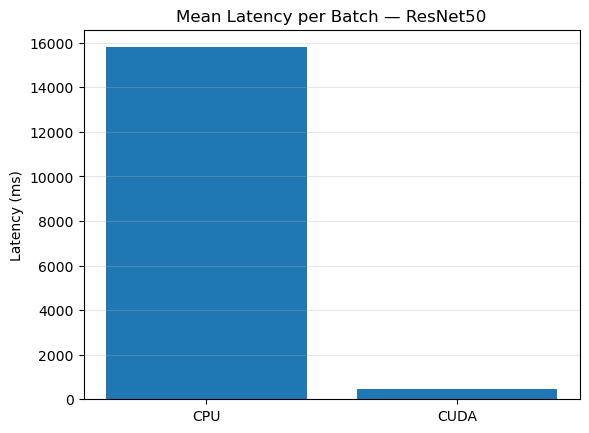

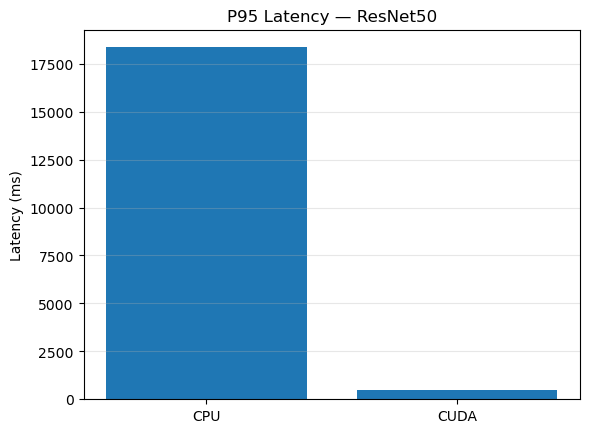

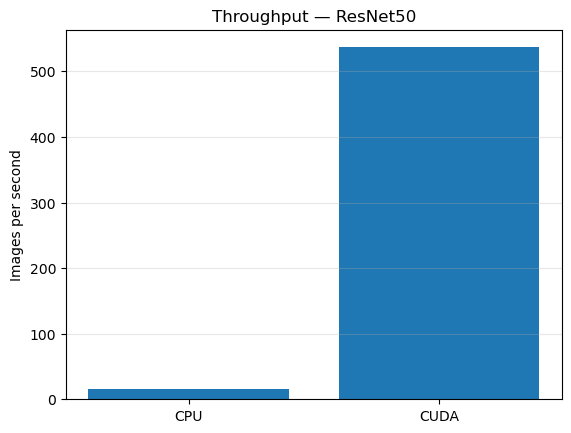


🚀 GPU Speedup vs CPU: 33.1x


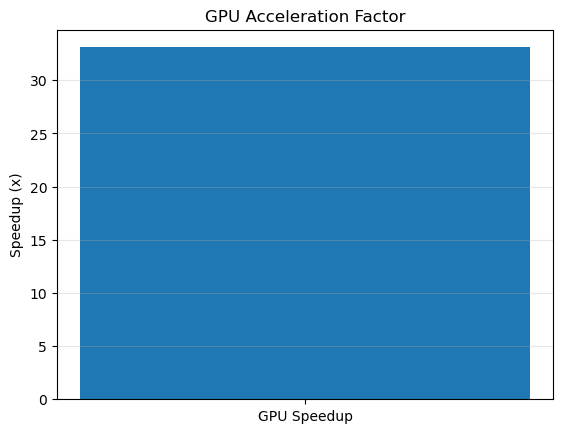

In [4]:
# =========================
# GRAPHIQUES
# =========================

devices = [r["device"] for r in results]
latencies = [r["mean_latency_ms"] for r in results]
p95 = [r["p95_latency_ms"] for r in results]
throughput = [r["throughput_img_s"] for r in results]

# -------- Latence moyenne --------
plt.figure()
plt.bar(devices, latencies)
plt.title("Mean Latency per Batch — ResNet50")
plt.ylabel("Latency (ms)")
plt.grid(axis="y", alpha=0.3)
plt.show()

# -------- P95 --------
plt.figure()
plt.bar(devices, p95)
plt.title("P95 Latency — ResNet50")
plt.ylabel("Latency (ms)")
plt.grid(axis="y", alpha=0.3)
plt.show()

# -------- Throughput --------
plt.figure()
plt.bar(devices, throughput)
plt.title("Throughput — ResNet50")
plt.ylabel("Images per second")
plt.grid(axis="y", alpha=0.3)
plt.show()

# -------- Speedup --------
if len(results) == 2:
    cpu_latency = results[0]["mean_latency_ms"]
    gpu_latency = results[1]["mean_latency_ms"]

    speedup = cpu_latency / gpu_latency

    print(f"\n🚀 GPU Speedup vs CPU: {speedup:.1f}x")

    plt.figure()
    plt.bar(["GPU Speedup"], [speedup])
    plt.title("GPU Acceleration Factor")
    plt.ylabel("Speedup (x)")
    plt.grid(axis="y", alpha=0.3)
    plt.show()


In [3]:
import torch
import torchvision.models as models
import numpy as np
import time
import os

# =========================
# ENERGY HELPERS
# =========================

# Valeurs de repli (estimation) si capteurs indisponibles
POWER_ESTIMATE_W = {
    "cpu": 45,
    "cuda": 90,
}

# ----- GPU NVIDIA (NVML) -----
GPU_ENERGY_AVAILABLE = False
GPU_ENERGY_REASON = "pynvml not initialized"
handle = None

try:
    import pynvml
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    GPU_ENERGY_AVAILABLE = True
    GPU_ENERGY_REASON = "ok"
except Exception as e:
    GPU_ENERGY_REASON = f"nvml init failed: {type(e).__name__}"


def gpu_energy_j():
    if not GPU_ENERGY_AVAILABLE:
        return None, GPU_ENERGY_REASON
    try:
        # Renvoie des milliJoules sur GPUs compatibles
        value_j = pynvml.nvmlDeviceGetTotalEnergyConsumption(handle) / 1000.0
        return value_j, "sensor_nvml"
    except Exception as e:
        return None, f"nvml read failed: {type(e).__name__}"


# ----- CPU RAPL (Linux) -----
RAPL_PATH = "/sys/class/powercap/intel-rapl:0/energy_uj"


def cpu_energy_j():
    if not os.path.exists(RAPL_PATH):
        return None, "rapl path not found"
    try:
        with open(RAPL_PATH) as f:
            return int(f.read()) / 1e6, "sensor_rapl"  # µJ -> J
    except Exception as e:
        return None, f"rapl read failed: {type(e).__name__}"


# =========================
# CONFIG
# =========================

BATCH_SIZE = 256
IMAGE_SIZE = 224
WARMUP = 10
ITERS = 50
DTYPE = torch.float32


# =========================
# Benchmark
# =========================

def run_benchmark(device):

    print(f"\n=== Running on {device.upper()} ===")

    model = models.resnet50(weights=None).to(device)
    model.eval()

    x_cpu = torch.rand((BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE), dtype=DTYPE)

    if device == "cuda":
        x = x_cpu.pin_memory().to(device, non_blocking=True)
    else:
        x = x_cpu

    # ---------- Warmup ----------
    with torch.no_grad():
        for _ in range(WARMUP):
            _ = model(x)
            if device == "cuda":
                torch.cuda.synchronize()

    # ---------- Energy start ----------
    if device == "cuda":
        e_start, start_reason = gpu_energy_j()
    else:
        e_start, start_reason = cpu_energy_j()

    # ---------- Timing ----------
    times = []

    with torch.no_grad():
        for _ in range(ITERS):

            start = time.perf_counter()
            _ = model(x)

            if device == "cuda":
                torch.cuda.synchronize()

            end = time.perf_counter()
            times.append(end - start)

    # ---------- Energy end ----------
    if device == "cuda":
        e_end, end_reason = gpu_energy_j()
    else:
        e_end, end_reason = cpu_energy_j()

    # ---------- Stats ----------
    times = np.array(times)

    latency_ms = times.mean() * 1000
    p95_ms = np.percentile(times, 95) * 1000
    throughput = BATCH_SIZE / times.mean()

    measured_energy = None
    if e_start is not None and e_end is not None:
        measured_energy = e_end - e_start

    # fallback estimation si mesure capteur indisponible
    total_time_s = float(times.sum())
    est_power_w = POWER_ESTIMATE_W.get(device)

    if measured_energy is not None:
        energy_total = measured_energy
        energy_source = "sensor"
        energy_reason = "ok"
    elif est_power_w is not None:
        energy_total = est_power_w * total_time_s
        energy_source = "estimated"
        energy_reason = f"start={start_reason}; end={end_reason}"
    else:
        energy_total = None
        energy_source = "unavailable"
        energy_reason = f"start={start_reason}; end={end_reason}"

    energy_per_img = None if energy_total is None else energy_total / (ITERS * BATCH_SIZE)

    print(f"Mean latency: {latency_ms:.2f} ms")
    print(f"P95 latency:  {p95_ms:.2f} ms")
    print(f"Throughput:   {throughput:.0f} images/sec")

    if energy_total is not None:
        print(f"Energy total: {energy_total:.6f} J ({energy_source})")
        print(f"Energy/img:   {energy_per_img:.8f} J")
    else:
        print("Energy:       unavailable")

    if energy_source != "sensor":
        print(f"Energy note:  {energy_reason}")

    return {
        "device": device.upper(),
        "mean_latency_ms": latency_ms,
        "p95_latency_ms": p95_ms,
        "throughput_img_s": throughput,
        "energy_j_total": energy_total,
        "energy_per_img_j": energy_per_img,
        "energy_source": energy_source,
        "energy_note": energy_reason,
    }


# =========================
# MAIN
# =========================

print("=== CPU vs GPU Stress Benchmark — ResNet50 ===")

results = []
results.append(run_benchmark("cpu"))

if torch.cuda.is_available():
    results.append(run_benchmark("cuda"))
else:
    print("\n⚠ GPU not detected")

print("\n=== SUMMARY ===")
for r in results:
    print(r)

=== CPU vs GPU Stress Benchmark — ResNet50 ===

=== Running on CPU ===
Mean latency: 14707.66 ms
P95 latency:  15134.30 ms
Throughput:   17 images/sec
Energy total: 33092.232849 J (estimated)
Energy/img:   2.58533069 J
Energy note:  start=rapl path not found; end=rapl path not found

=== Running on CUDA ===
Mean latency: 476.94 ms
P95 latency:  477.50 ms
Throughput:   537 images/sec
Energy total: 2146.226724 J (estimated)
Energy/img:   0.16767396 J
Energy note:  start=nvml init failed: NVMLError_LibraryNotFound; end=nvml init failed: NVMLError_LibraryNotFound

=== SUMMARY ===
{'device': 'CPU', 'mean_latency_ms': np.float64(14707.659044000102), 'p95_latency_ms': np.float64(15134.30317999937), 'throughput_img_s': np.float64(17.405897106680182), 'energy_j_total': 33092.232849000226, 'energy_per_img_j': 2.5853306913281426, 'energy_source': 'estimated', 'energy_note': 'start=rapl path not found; end=rapl path not found'}
{'device': 'CUDA', 'mean_latency_ms': np.float64(476.9392720002361), '